# BIZ 프로젝트 : 부실기업 예측 모형에 관한 연구

## Step3 : 모델링

할거 : 21,22(2개년도)년도 딥러닝 모델 구축

### 0. 라이브러리 및 데이터 불러오기

라이브러리 불러오기

In [170]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Flatten, Dense, LSTM, GRU, Reshape
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

폰트 지정

In [171]:
import platform
from matplotlib import rc

# 운영 체제에 따라 폰트 설정
if platform.system() == 'Windows':  # Windows 환경
    rc('font', family='Malgun Gothic')  # 맑은 고딕

# 음수 표시 가능하도록 설정
plt.rcParams['axes.unicode_minus'] = False

데이터 불러오기(21 to 22 2개년도 데이터)

In [172]:
RANDOM_STATE = 110

data_21to22 = pd.read_csv("../../project/data/data_21to22.csv", encoding='utf-8-sig', low_memory=False)
print(data_21to22.shape)

(27603, 90)


타겟비율 시각화

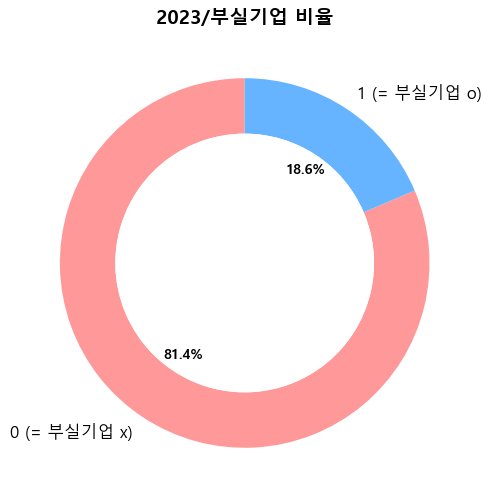

In [173]:
# '2023/부실기업' 비율 계산
value_counts = data_21to22['2023/부실기업'].value_counts()
labels = ['1 (= 부실기업 o)' if label == 1 else '0 (= 부실기업 x)' for label in value_counts.index]
sizes = value_counts.values

# 색상 설정
colors = ['#ff9999','#66b3ff']

# 도넛 차트 시각화
fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(aspect="equal"))

wedges, texts, autotexts = ax.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90, wedgeprops=dict(width=0.3))

# 도넛 차트의 가운데에 텍스트 추가
centre_circle = plt.Circle((0, 0), 0.70, fc='white')
fig.gca().add_artist(centre_circle)

# 텍스트 스타일 설정
plt.setp(autotexts, size=10, weight="bold", color="black")
plt.setp(texts, size=12)

# 차트 제목 추가
plt.title('2023/부실기업 비율', fontsize=14, weight='bold')

# 차트 표시
plt.show()

데이터 불균형 -> 평가지표로 accuracy(정확도)가 아닌 F1-score를 기준으로 한다.

### 모델링(개념)

#### [ CNN 학습 프로세스 예시 ]

| 업체코드 | 총자산증가율 | 유형자산증가율 | 유동자산증가율 | 매출액증가율 | 부실기업 |
|---------|--------------|---------------|---------------|-------------|----------|
| A       | 10.5         | 5.0           |  8.3          |  12.0       |  0       |
| B       | 7.2         | 3.1           |  6.4           |  9.5        |  1       |

2.1. 2D 형태로 변환

첫 번째 기업(A)의 데이터, 두 번째 기업(B)의 데이터를 2D 배열로 변환

[  
ㅡ[10.5, 5.0, 8.3, 12.0, 0],  # A 기업  
ㅡ[7.2, 3.1, 6.4, 9.5, 1]    # B 기업  
]  

2.2. 차원 추가  

(cov1d) CNN은 입력 데이터를 3차원 배열로 처리  
-> 일반적으로 (샘플, 특성, 채널)로 구성 (이미지의 경우 4차원 배열인 cov2d 이용)
   
샘플 수: 데이터셋에 있는 샘플의 수  
높이: 각 샘플의 특성 수 (테이블에서 열의 수)  
채널 수: 이미지의 색상 채널 수 (흑백 이미지는 1, RGB 이미지는 3)  

최종적으로, 이 데이터는 다음과 같은 3차원 배열로 표현    
모델에 입력되는 데이터의 형태는 (2, 4, 1)    
즉, 2개의 샘플이 각각 4개의 특성을 갖고, 채널 1로 설정된 것    

#### [ LSTM, GRU 학습 프로세스 예시 ]

- 첫 번째 타임 스텝: 2021년의 재무비율 데이터
- 두 번째 타임 스텝: 2022년의 재무비율 데이터

모델은 첫 번째 타임 스텝의 데이터를 입력받아 처리한 후, 두 번째 타임 스텝의 데이터를 입력받아 처리  
이 과정에서 모델은 각 타임 스텝의 정보를 유지하고, 시계열 특성을 학습  

### 1. 데이터 추가 전처리

In [ ]:
# 종속 변수 설정
y = data_21to22['2023/부실기업']

# 연도별 특성 분리
X_2021 = data_21to22.filter(like='2021')  # 2021년 데이터
X_2022 = data_21to22.filter(like='2022')  # 2022년 데이터

# 재무비율 추출 함수
def extract_ratio_columns(df, year):
    return df.columns.str.replace(f'{year}/', '')

# 2021년과 2022년의 재무비율 추출
ratios_2021 = extract_ratio_columns(X_2021, '2021')
ratios_2022 = extract_ratio_columns(X_2022, '2022')

# 공통 재무비율 찾기
common_ratios = ratios_2021.intersection(ratios_2022)

# 공통 재무비율을 포함하는 변수명 생성
common_columns_2021 = [f'2021/{ratio}' for ratio in common_ratios]
common_columns_2022 = [f'2022/{ratio}' for ratio in common_ratios]

# 공통 변수만 사용하여 데이터 결합
X_2021_common = X_2021[common_columns_2021]
X_2022_common = X_2022[common_columns_2022]

# 전체 특성 결합 (타임 스텝을 위해 배열로 변환)
X_common = pd.concat([X_2021_common, X_2022_common], axis=1)

# 모든 변수를 사용하여 데이터 결합
X_all = pd.concat([X_2021, X_2022], axis=1)

# 데이터 분할 (70:30 비율)
X_common_train, X_common_test, y_train, y_test = train_test_split(X_common, y, test_size=0.3, random_state=RANDOM_STATE)
X_all_train, X_all_test, _, _ = train_test_split(X_all, y, test_size=0.3, random_state=RANDOM_STATE)

# 데이터 정규화
scaler_common = StandardScaler()
X_common_train_scaled = scaler_common.fit_transform(X_common_train)
X_common_test_scaled = scaler_common.transform(X_common_test)

scaler_all = StandardScaler()
X_all_train_scaled = scaler_all.fit_transform(X_all_train)
X_all_test_scaled = scaler_all.transform(X_all_test)

# 변수명을 유지하기 위해 DataFrame으로 변환
X_common_train_scaled_df = pd.DataFrame(X_common_train_scaled, columns=X_common_train.columns)
X_common_test_scaled_df = pd.DataFrame(X_common_test_scaled, columns=X_common_test.columns)

X_all_train_scaled_df = pd.DataFrame(X_all_train_scaled, columns=X_all_train.columns)
X_all_test_scaled_df = pd.DataFrame(X_all_test_scaled, columns=X_all_test.columns)

# 타임 스텝 설정
timesteps = 2  # 2021년과 2022년으로 2개의 타임 스텝으로 설정  # (샘플 수, 타임 스텝, 특성 수)
X_train_lstm = X_common_train_scaled_df.values.reshape((X_common_train_scaled_df.shape[0], timesteps, -1)) 
X_test_lstm = X_common_test_scaled_df.values.reshape((X_common_test_scaled_df.shape[0], timesteps, -1))

정규화    
-> 수렴속도 향상(학습 속도 향상)  
-> 수치적 안정성 향상(계산과정에서 발생할수 있는 오버플로우나 언더플로우 문제 줄일수 있음)  

타임스텝  
-> timesteps = 2 이면 과거 2년의 데이터 가지고 해당년도의 값을 예측

In [175]:
# 타임 스텝 확인
print("X_train_lstm shape:", X_train_lstm.shape)
print("X_test_lstm shape:", X_test_lstm.shape)

# 첫 번째 샘플의 타임 스텝별 데이터 확인
print("첫 번째 샘플의 첫 번째 타임 스텝 데이터:", X_train_lstm[0, 0, :])
print("첫 번째 샘플의 두 번째 타임 스텝 데이터:", X_train_lstm[0, 1, :])

X_train_lstm shape: (19322, 2, 21)
X_test_lstm shape: (8281, 2, 21)
첫 번째 샘플의 첫 번째 타임 스텝 데이터: [ 0.03807207 -0.0020328   0.05400356  0.05899398  0.07017119  0.14827777
  0.00180214  0.61243826 -0.33427654 -0.185362   -0.19290163 -0.19358192
 -0.03935053 -0.35014204  0.41301943  0.25458916  0.33200608 -0.04324597
 -0.03086146 -0.12714346 -0.22720773]
첫 번째 샘플의 두 번째 타임 스텝 데이터: [-0.54167093 -0.62132018 -0.51073733 -0.55508638 -0.57985577  0.097176
 -0.0018005  -0.13981697 -0.35060469 -0.18735672 -0.19095395 -0.19360187
 -0.06447123 -0.34301056  0.35340432  0.24664365  0.25629906 -0.07094113
 -0.02741867 -0.12251024 -0.21648227]


In [176]:
# 데이터 shape 출력
print("X_all_train_scaled_df shape:", X_all_train_scaled_df.shape)  # MLP와 CNN 학습에 사용
print("X_all_test_scaled_df shape:", X_all_test_scaled_df.shape)    # MLP와 CNN 테스트에 사용
print("X_train_lstm shape:", X_train_lstm.shape)                    # LSTM과 GRU 학습에 사용
print("X_test_lstm shape:", X_test_lstm.shape)                      # LSTM과 GRU 테스트에 사용
print("y_train shape:", y_train.shape)                              # 종속 변수 학습 데이터
print("y_test shape:", y_test.shape)                                # 종속 변수 테스트 데이터

X_all_train_scaled_df shape: (19322, 86)
X_all_test_scaled_df shape: (8281, 86)
X_train_lstm shape: (19322, 2, 21)
X_test_lstm shape: (8281, 2, 21)
y_train shape: (19322,)
y_test shape: (8281,)


In [181]:
X_all_train_scaled_df.columns

Index(['2021/영업이익증가율', '2021/순이익증가율', '2021/총자본영업이익율', '2021/기업법인세비용차감전순이익율',
       '2021/기업순이익율', '2021/경영자본영업이익율', '2021/자기자본순이익율',
       '2021/자본금법인세비용차감전순이익율', '2021/자본금순이익율', '2021/매출액법인세비용차감전순이익율',
       '2021/조세/조세차감전순이익비율', '2021/차입금평균이자율', '2021/금융비용/총비용비율',
       '2021/영업이익이자보상비율', '2021/법인세차감전순이익이자보상비율', '2021/상환계수(세전이익)',
       '2021/부채상환계수', '2021/대출효율성계수(법인세비용차감전순이익)', '2021/EBITDA대금융비용',
       '2021/자기자본비율', '2021/당좌비율', '2021/현금비율', '2021/비유동자산비율', '2021/부채비율',
       '2021/유동부채비율', '2021/차입금의존도', '2021/차입금/매출액비율', '2021/비유동부채/순운전자본비율',
       '2021/순운전자본/총자본비율', '2021/사내유보율', '2021/유보액/총자산비율', '2021/총C/F대부채비율',
       '2021/총C/F대매출액비율', '2021/매출액(종업원1인당)', '2021/법인세비용차감전순이익(종업원1인당)',
       '2021/순이익(종업원1인당)', '2021/노동장비율(종업원1인당)', '2021/자본집약도(종업원1인당)',
       '2021/법인세차감전순이익(구성비)', '2021/인건비(구성비)', '2021/금융비용(구성비)',
       '2021/임차료(구성비)', '2022/총자산증가율', '2022/매출액증가율', '2022/총자본영업이익율',
       '2022/총자본법인세비용차감전순이익율', '2022/총자본순이익율', '2022/기업법인세비용차감전순이익율',
       

In [182]:
X_common_train_scaled_df.columns

Index(['2021/총자본영업이익율', '2021/기업법인세비용차감전순이익율', '2021/경영자본영업이익율',
       '2021/자본금법인세비용차감전순이익율', '2021/자본금순이익율', '2021/매출액법인세비용차감전순이익율',
       '2021/조세/조세차감전순이익비율', '2021/차입금평균이자율', '2021/금융비용/총비용비율',
       '2021/영업이익이자보상비율', '2021/법인세차감전순이익이자보상비율', '2021/EBITDA대금융비용',
       '2021/현금비율', '2021/유동부채비율', '2021/순운전자본/총자본비율', '2021/사내유보율',
       '2021/유보액/총자산비율', '2021/순이익(종업원1인당)', '2021/법인세차감전순이익(구성비)',
       '2021/금융비용(구성비)', '2021/임차료(구성비)', '2022/총자본영업이익율',
       '2022/기업법인세비용차감전순이익율', '2022/경영자본영업이익율', '2022/자본금법인세비용차감전순이익율',
       '2022/자본금순이익율', '2022/매출액법인세비용차감전순이익율', '2022/조세/조세차감전순이익비율',
       '2022/차입금평균이자율', '2022/금융비용/총비용비율', '2022/영업이익이자보상비율',
       '2022/법인세차감전순이익이자보상비율', '2022/EBITDA대금융비용', '2022/현금비율', '2022/유동부채비율',
       '2022/순운전자본/총자본비율', '2022/사내유보율', '2022/유보액/총자산비율', '2022/순이익(종업원1인당)',
       '2022/법인세차감전순이익(구성비)', '2022/금융비용(구성비)', '2022/임차료(구성비)'],
      dtype='object')

---

### 2. 모델링

노드수 조절(64)

Epoch 1/10
484/484 [==============================] - 2s 2ms/step - loss: 0.2484 - accuracy: 0.8942 - val_loss: 0.2050 - val_accuracy: 0.9092
Epoch 2/10
484/484 [==============================] - 1s 2ms/step - loss: 0.1850 - accuracy: 0.9185 - val_loss: 0.1889 - val_accuracy: 0.9138
Epoch 3/10
484/484 [==============================] - 1s 2ms/step - loss: 0.1647 - accuracy: 0.9262 - val_loss: 0.1843 - val_accuracy: 0.9185
Epoch 4/10
484/484 [==============================] - 1s 2ms/step - loss: 0.1507 - accuracy: 0.9323 - val_loss: 0.1736 - val_accuracy: 0.9208
Epoch 5/10
484/484 [==============================] - 1s 1ms/step - loss: 0.1398 - accuracy: 0.9360 - val_loss: 0.1884 - val_accuracy: 0.9172
Epoch 6/10
484/484 [==============================] - 1s 1ms/step - loss: 0.1324 - accuracy: 0.9416 - val_loss: 0.1744 - val_accuracy: 0.9239
Epoch 7/10
484/484 [==============================] - 1s 1ms/step - loss: 0.1249 - accuracy: 0.9447 - val_loss: 0.1728 - val_accuracy: 0.9260
Epoch 

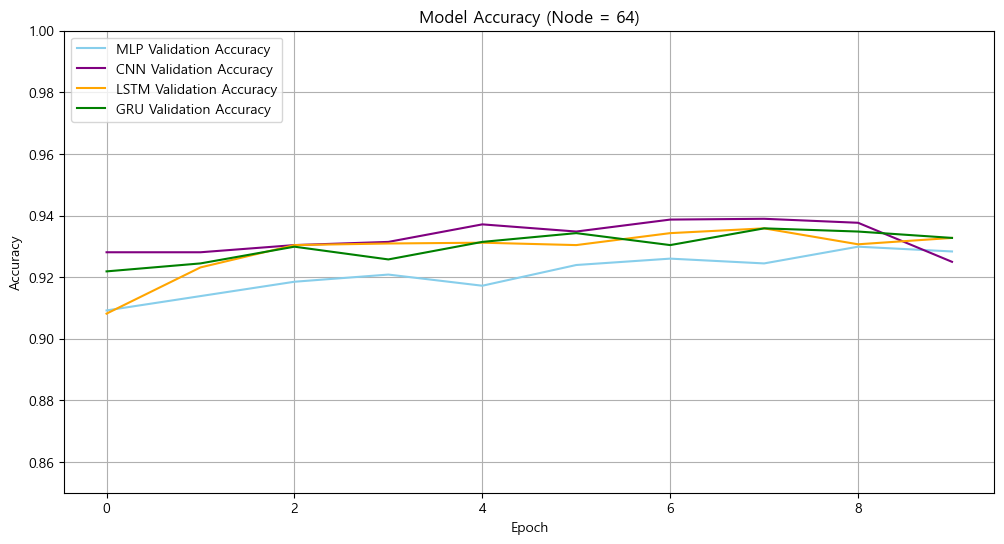

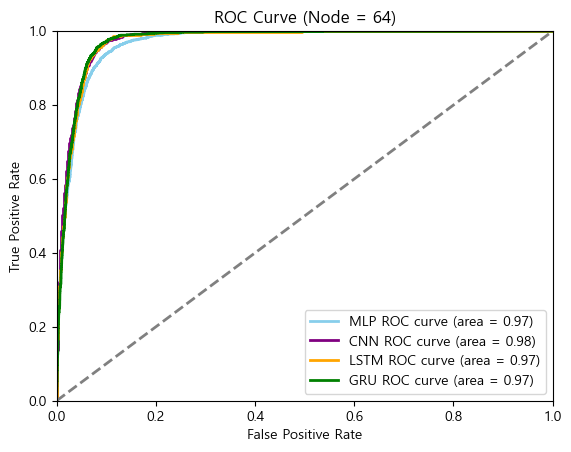

In [178]:
#----- 모델 구축 (64) -----#

# MLP 모델
mlp_model_64 = Sequential()
mlp_model_64.add(Dense(64, activation='relu', input_shape=(X_all_train_scaled.shape[1],)))
mlp_model_64.add(Dense(64, activation='relu'))  
mlp_model_64.add(Dense(1, activation='sigmoid'))  
mlp_model_64.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])

# CNN 모델
cnn_model_64 = Sequential()
cnn_model_64.add(Reshape((X_all_train_scaled.shape[1], 1), input_shape=(X_all_train_scaled.shape[1],)))
cnn_model_64.add(Conv1D(64, kernel_size=2, activation='relu', padding='same'))  
cnn_model_64.add(Conv1D(64, kernel_size=2, activation='relu', padding='same')) 
cnn_model_64.add(Flatten())
cnn_model_64.add(Dense(1, activation='sigmoid'))
cnn_model_64.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])

# LSTM 모델
lstm_model_64 = Sequential()
lstm_model_64.add(LSTM(64, activation='relu', return_sequences=True, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])))
lstm_model_64.add(LSTM(64, activation='relu'))  
lstm_model_64.add(Dense(1, activation='sigmoid'))  
lstm_model_64.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])

# GRU 모델
gru_model_64 = Sequential()
gru_model_64.add(GRU(64, activation='relu', return_sequences=True, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2]))) 
gru_model_64.add(GRU(64, activation='relu'))  
gru_model_64.add(Dense(1, activation='sigmoid'))  
gru_model_64.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])

#----- 모델 학습 -----#

# MLP 학습 및 평가
mlp_history_64 = mlp_model_64.fit(X_all_train_scaled, y_train, epochs=10, batch_size=32, validation_split=0.2, verbose=1)
mlp_predictions_proba_64 = mlp_model_64.predict(X_all_test_scaled)
mlp_predictions_64 = (mlp_predictions_proba_64 > 0.5).astype(int)

# Accuracy와 F1-Score 출력
mlp_accuracy_64 = mlp_model_64.evaluate(X_all_test_scaled, y_test, verbose=0)[1]
mlp_f1_score_64 = f1_score(y_test, mlp_predictions_64)
print(f"MLP Accuracy (64): {mlp_accuracy_64:.4f}, F1 Score: {mlp_f1_score_64:.4f}")

# CNN 학습 및 평가
X_train_cnn = X_all_train_scaled.reshape((X_all_train_scaled.shape[0], X_all_train_scaled.shape[1], 1))  
X_test_cnn = X_all_test_scaled.reshape((X_all_test_scaled.shape[0], X_all_test_scaled.shape[1], 1))
cnn_history_64 = cnn_model_64.fit(X_train_cnn, y_train, epochs=10, batch_size=32, validation_split=0.2, verbose=1)  
cnn_predictions_proba_64 = cnn_model_64.predict(X_test_cnn)
cnn_predictions_64 = (cnn_predictions_proba_64 > 0.5).astype(int)

# Accuracy와 F1-Score 출력
cnn_accuracy_64 = cnn_model_64.evaluate(X_test_cnn, y_test, verbose=0)[1]  
cnn_f1_score_64 = f1_score(y_test, cnn_predictions_64)
print(f"CNN Accuracy (64): {cnn_accuracy_64:.4f}, F1 Score: {cnn_f1_score_64:.4f}")

# LSTM 학습 및 평가
lstm_history_64 = lstm_model_64.fit(X_train_lstm, y_train, epochs=10, batch_size=32, validation_split=0.2, verbose=1) 
lstm_predictions_proba_64 = lstm_model_64.predict(X_test_lstm)
lstm_predictions_64 = (lstm_predictions_proba_64 > 0.5).astype(int)

# Accuracy와 F1-Score 출력
lstm_accuracy_64 = lstm_model_64.evaluate(X_test_lstm, y_test, verbose=0)[1]  
lstm_f1_score_64 = f1_score(y_test, lstm_predictions_64)
print(f"LSTM Accuracy (64): {lstm_accuracy_64:.4f}, F1 Score: {lstm_f1_score_64:.4f}")

# GRU 학습 및 평가
gru_history_64 = gru_model_64.fit(X_train_lstm, y_train, epochs=10, batch_size=32, validation_split=0.2, verbose=1) 
gru_predictions_proba_64 = gru_model_64.predict(X_test_lstm)
gru_predictions_64 = (gru_predictions_proba_64 > 0.5).astype(int)

# Accuracy와 F1-Score 출력
gru_accuracy_64 = gru_model_64.evaluate(X_test_lstm, y_test, verbose=0)[1]  
gru_f1_score_64 = f1_score(y_test, gru_predictions_64)
print(f"GRU Accuracy (64): {gru_accuracy_64:.4f}, F1 Score: {gru_f1_score_64:.4f}")

#----- 시각화 -----#

# Accuracy 시각화
plt.figure(figsize=(12, 6))

plt.plot(mlp_history_64.history['val_accuracy'], label='MLP Validation Accuracy', color='skyblue')     # MLP 
plt.plot(cnn_history_64.history['val_accuracy'], label='CNN Validation Accuracy', color='purple')      # CNN 
plt.plot(lstm_history_64.history['val_accuracy'], label='LSTM Validation Accuracy', color='orange')    # LSTM 
plt.plot(gru_history_64.history['val_accuracy'], label='GRU Validation Accuracy', color='green')       # GRU 

plt.title('Model Accuracy (Node = 64)')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.ylim(0.85, 1)
plt.grid()
plt.show()

# ROC Curve 시각화
plt.figure()
fpr_mlp, tpr_mlp, _ = roc_curve(y_test, mlp_predictions_proba_64)
roc_auc_mlp = auc(fpr_mlp, tpr_mlp)
plt.plot(fpr_mlp, tpr_mlp, color='skyblue', lw=2, label='MLP ROC curve (area = %0.2f)' % roc_auc_mlp)

fpr_cnn, tpr_cnn, _ = roc_curve(y_test, cnn_predictions_proba_64)
roc_auc_cnn = auc(fpr_cnn, tpr_cnn)
plt.plot(fpr_cnn, tpr_cnn, color='purple', lw=2, label='CNN ROC curve (area = %0.2f)' % roc_auc_cnn)

fpr_lstm, tpr_lstm, _ = roc_curve(y_test, lstm_predictions_proba_64)
roc_auc_lstm = auc(fpr_lstm, tpr_lstm)
plt.plot(fpr_lstm, tpr_lstm, color='orange', lw=2, label='LSTM ROC curve (area = %0.2f)' % roc_auc_lstm)

fpr_gru, tpr_gru, _ = roc_curve(y_test, gru_predictions_proba_64)
roc_auc_gru = auc(fpr_gru, tpr_gru)
plt.plot(fpr_gru, tpr_gru, color='green', lw=2, label='GRU ROC curve (area = %0.2f)' % roc_auc_gru)

plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Node = 64)')
plt.legend(loc="lower right")
plt.show()

노드수 조절(128)

Epoch 1/10
484/484 [==============================] - 2s 2ms/step - loss: 0.2345 - accuracy: 0.8986 - val_loss: 0.2042 - val_accuracy: 0.9082
Epoch 2/10
484/484 [==============================] - 1s 2ms/step - loss: 0.1751 - accuracy: 0.9229 - val_loss: 0.1796 - val_accuracy: 0.9206
Epoch 3/10
484/484 [==============================] - 1s 2ms/step - loss: 0.1552 - accuracy: 0.9327 - val_loss: 0.1734 - val_accuracy: 0.9245
Epoch 4/10
484/484 [==============================] - 1s 2ms/step - loss: 0.1427 - accuracy: 0.9386 - val_loss: 0.1729 - val_accuracy: 0.9211
Epoch 5/10
484/484 [==============================] - 1s 2ms/step - loss: 0.1312 - accuracy: 0.9417 - val_loss: 0.1744 - val_accuracy: 0.9213
Epoch 6/10
484/484 [==============================] - 1s 2ms/step - loss: 0.1224 - accuracy: 0.9472 - val_loss: 0.1600 - val_accuracy: 0.9322
Epoch 7/10
484/484 [==============================] - 1s 2ms/step - loss: 0.1152 - accuracy: 0.9499 - val_loss: 0.1700 - val_accuracy: 0.9276
Epoch 

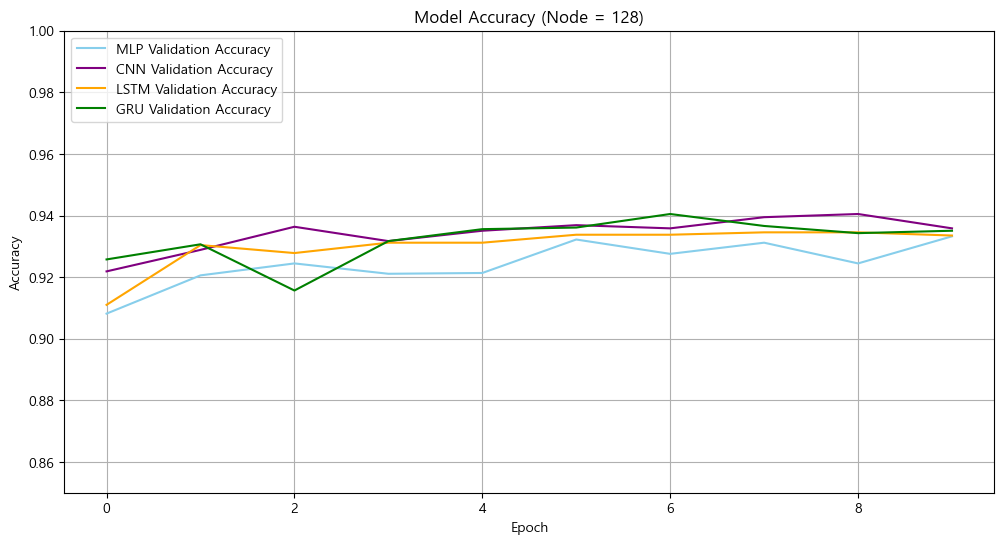

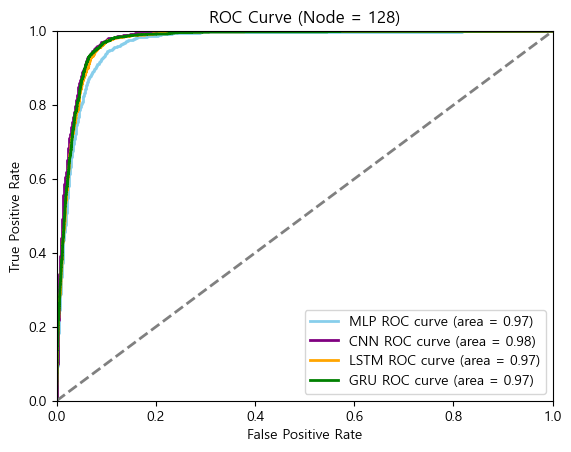

In [179]:
#----- 모델 구축 (128) -----#

# MLP 모델
mlp_model_128 = Sequential()
mlp_model_128.add(Dense(128, activation='relu', input_shape=(X_all_train_scaled_df.shape[1],)))
mlp_model_128.add(Dense(128, activation='relu'))  
mlp_model_128.add(Dense(1, activation='sigmoid'))  
mlp_model_128.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])

# CNN 모델
cnn_model_128 = Sequential()
cnn_model_128.add(Reshape((X_all_train_scaled_df.shape[1], 1), input_shape=(X_all_train_scaled_df.shape[1],)))
cnn_model_128.add(Conv1D(128, kernel_size=2, activation='relu', padding='same'))  
cnn_model_128.add(Conv1D(128, kernel_size=2, activation='relu', padding='same')) 
cnn_model_128.add(Flatten())
cnn_model_128.add(Dense(1, activation='sigmoid'))
cnn_model_128.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])

# LSTM 모델
lstm_model_128 = Sequential()
lstm_model_128.add(LSTM(128, activation='relu', return_sequences=True, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])))
lstm_model_128.add(LSTM(128, activation='relu'))  
lstm_model_128.add(Dense(1, activation='sigmoid'))  
lstm_model_128.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])

# GRU 모델
gru_model_128 = Sequential()
gru_model_128.add(GRU(128, activation='relu', return_sequences=True, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2]))) 
gru_model_128.add(GRU(128, activation='relu'))  
gru_model_128.add(Dense(1, activation='sigmoid'))  
gru_model_128.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])

#----- 모델 학습 -----#

# MLP 학습 및 평가
mlp_history_128 = mlp_model_128.fit(X_all_train_scaled_df, y_train, epochs=10, batch_size=32, validation_split=0.2, verbose=1)
mlp_predictions_proba_128 = mlp_model_128.predict(X_all_test_scaled_df)
mlp_predictions_128 = (mlp_predictions_proba_128 > 0.5).astype(int)

# Accuracy와 F1-Score 출력
mlp_accuracy_128 = mlp_model_128.evaluate(X_all_test_scaled_df, y_test, verbose=0)[1]
mlp_f1_score_128 = f1_score(y_test, mlp_predictions_128)
print(f"MLP Accuracy (128): {mlp_accuracy_128:.4f}, F1 Score: {mlp_f1_score_128:.4f}")

# CNN 학습 및 평가
X_train_cnn = X_all_train_scaled_df.values.reshape((X_all_train_scaled_df.shape[0], X_all_train_scaled_df.shape[1], 1))  
X_test_cnn = X_all_test_scaled_df.values.reshape((X_all_test_scaled_df.shape[0], X_all_test_scaled_df.shape[1], 1))
cnn_history_128 = cnn_model_128.fit(X_train_cnn, y_train, epochs=10, batch_size=32, validation_split=0.2, verbose=1)  
cnn_predictions_proba_128 = cnn_model_128.predict(X_test_cnn)
cnn_predictions_128 = (cnn_predictions_proba_128 > 0.5).astype(int)

# Accuracy와 F1-Score 출력
cnn_accuracy_128 = cnn_model_128.evaluate(X_test_cnn, y_test, verbose=0)[1]  
cnn_f1_score_128 = f1_score(y_test, cnn_predictions_128)
print(f"CNN Accuracy (128): {cnn_accuracy_128:.4f}, F1 Score: {cnn_f1_score_128:.4f}")

# LSTM 학습 및 평가
lstm_history_128 = lstm_model_128.fit(X_train_lstm, y_train, epochs=10, batch_size=32, validation_split=0.2, verbose=1) 
lstm_predictions_proba_128 = lstm_model_128.predict(X_test_lstm)
lstm_predictions_128 = (lstm_predictions_proba_128 > 0.5).astype(int)

# Accuracy와 F1-Score 출력
lstm_accuracy_128 = lstm_model_128.evaluate(X_test_lstm, y_test, verbose=0)[1]  
lstm_f1_score_128 = f1_score(y_test, lstm_predictions_128)
print(f"LSTM Accuracy (128): {lstm_accuracy_128:.4f}, F1 Score: {lstm_f1_score_128:.4f}")

# GRU 학습 및 평가
gru_history_128 = gru_model_128.fit(X_train_lstm, y_train, epochs=10, batch_size=32, validation_split=0.2, verbose=1) 
gru_predictions_proba_128 = gru_model_128.predict(X_test_lstm)
gru_predictions_128 = (gru_predictions_proba_128 > 0.5).astype(int)

# Accuracy와 F1-Score 출력
gru_accuracy_128 = gru_model_128.evaluate(X_test_lstm, y_test, verbose=0)[1]  
gru_f1_score_128 = f1_score(y_test, gru_predictions_128)
print(f"GRU Accuracy (128): {gru_accuracy_128:.4f}, F1 Score: {gru_f1_score_128:.4f}")

#----- 시각화 -----#

# Accuracy 시각화
plt.figure(figsize=(12, 6))

plt.plot(mlp_history_128.history['val_accuracy'], label='MLP Validation Accuracy', color='skyblue')     # MLP 
plt.plot(cnn_history_128.history['val_accuracy'], label='CNN Validation Accuracy', color='purple')   # CNN 
plt.plot(lstm_history_128.history['val_accuracy'], label='LSTM Validation Accuracy', color='orange') # LSTM 
plt.plot(gru_history_128.history['val_accuracy'], label='GRU Validation Accuracy', color='green')    # GRU 

plt.title('Model Accuracy (Node = 128)')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.ylim(0.85, 1)
plt.grid()
plt.show()

# ROC Curve 시각화
plt.figure()
fpr_mlp, tpr_mlp, _ = roc_curve(y_test, mlp_predictions_proba_128)
roc_auc_mlp = auc(fpr_mlp, tpr_mlp)
plt.plot(fpr_mlp, tpr_mlp, color='skyblue', lw=2, label='MLP ROC curve (area = %0.2f)' % roc_auc_mlp)

fpr_cnn, tpr_cnn, _ = roc_curve(y_test, cnn_predictions_proba_128)
roc_auc_cnn = auc(fpr_cnn, tpr_cnn)
plt.plot(fpr_cnn, tpr_cnn, color='purple', lw=2, label='CNN ROC curve (area = %0.2f)' % roc_auc_cnn)

fpr_lstm, tpr_lstm, _ = roc_curve(y_test, lstm_predictions_proba_128)
roc_auc_lstm = auc(fpr_lstm, tpr_lstm)
plt.plot(fpr_lstm, tpr_lstm, color='orange', lw=2, label='LSTM ROC curve (area = %0.2f)' % roc_auc_lstm)

fpr_gru, tpr_gru, _ = roc_curve(y_test, gru_predictions_proba_128)
roc_auc_gru = auc(fpr_gru, tpr_gru)
plt.plot(fpr_gru, tpr_gru, color='green', lw=2, label='GRU ROC curve (area = %0.2f)' % roc_auc_gru)

plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Node = 128)')
plt.legend(loc="lower right")
plt.show()

노드수 조절(256)

Epoch 1/10
484/484 [==============================] - 2s 2ms/step - loss: 0.2245 - accuracy: 0.9033 - val_loss: 0.1921 - val_accuracy: 0.9154
Epoch 2/10
484/484 [==============================] - 1s 2ms/step - loss: 0.1720 - accuracy: 0.9233 - val_loss: 0.1767 - val_accuracy: 0.9201
Epoch 3/10
484/484 [==============================] - 1s 2ms/step - loss: 0.1519 - accuracy: 0.9352 - val_loss: 0.1834 - val_accuracy: 0.9211
Epoch 4/10
484/484 [==============================] - 1s 2ms/step - loss: 0.1377 - accuracy: 0.9411 - val_loss: 0.1816 - val_accuracy: 0.9180
Epoch 5/10
484/484 [==============================] - 1s 2ms/step - loss: 0.1274 - accuracy: 0.9457 - val_loss: 0.1708 - val_accuracy: 0.9273
Epoch 6/10
484/484 [==============================] - 1s 2ms/step - loss: 0.1179 - accuracy: 0.9499 - val_loss: 0.1759 - val_accuracy: 0.9232
Epoch 7/10
484/484 [==============================] - 1s 2ms/step - loss: 0.1078 - accuracy: 0.9545 - val_loss: 0.1708 - val_accuracy: 0.9307
Epoch 

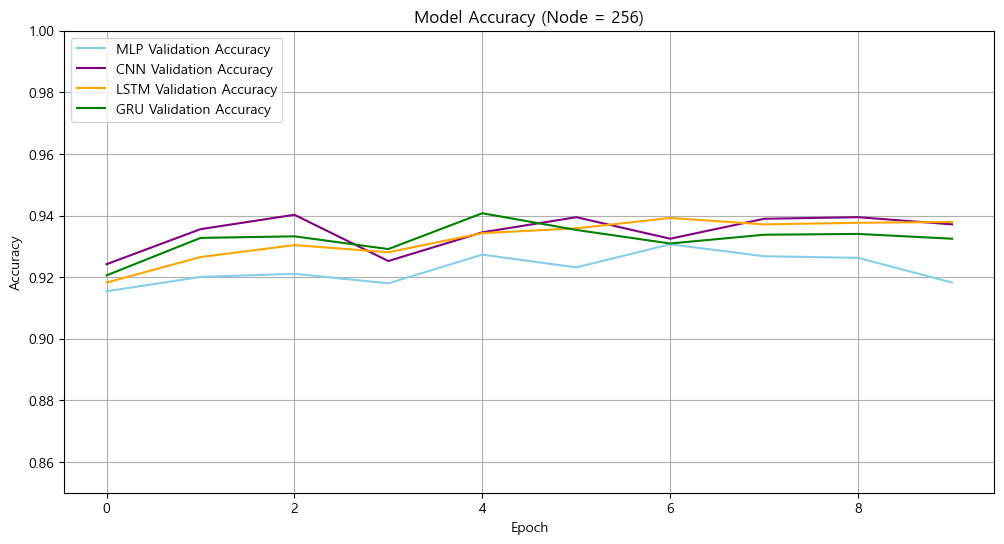

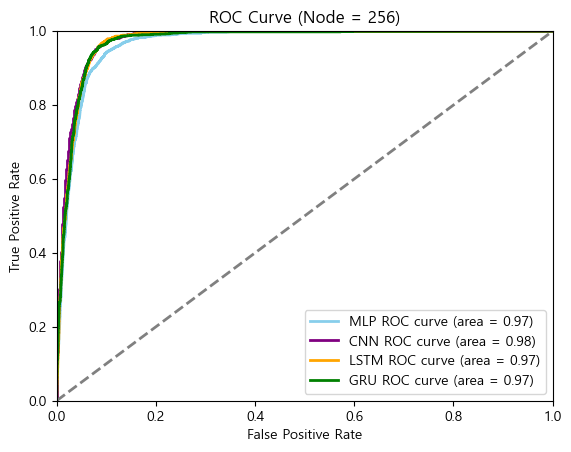

In [180]:
#----- 모델 구축 (256) -----#

# MLP 모델
mlp_model_256 = Sequential()
mlp_model_256.add(Dense(256, activation='relu', input_shape=(X_all_train_scaled_df.shape[1],)))
mlp_model_256.add(Dense(256, activation='relu'))  
mlp_model_256.add(Dense(1, activation='sigmoid'))  
mlp_model_256.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])

# CNN 모델
cnn_model_256 = Sequential()
cnn_model_256.add(Reshape((X_all_train_scaled_df.shape[1], 1), input_shape=(X_all_train_scaled_df.shape[1],)))
cnn_model_256.add(Conv1D(256, kernel_size=2, activation='relu', padding='same'))  
cnn_model_256.add(Conv1D(256, kernel_size=2, activation='relu', padding='same')) 
cnn_model_256.add(Flatten())
cnn_model_256.add(Dense(1, activation='sigmoid'))
cnn_model_256.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])

# LSTM 모델
lstm_model_256 = Sequential()
lstm_model_256.add(LSTM(256, activation='relu', return_sequences=True, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])))
lstm_model_256.add(LSTM(256, activation='relu'))  
lstm_model_256.add(Dense(1, activation='sigmoid'))  
lstm_model_256.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])

# GRU 모델
gru_model_256 = Sequential()
gru_model_256.add(GRU(256, activation='relu', return_sequences=True, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2]))) 
gru_model_256.add(GRU(256, activation='relu'))  
gru_model_256.add(Dense(1, activation='sigmoid'))  
gru_model_256.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])

#----- 모델 학습 -----#

# MLP 학습 및 평가
mlp_history_256 = mlp_model_256.fit(X_all_train_scaled_df, y_train, epochs=10, batch_size=32, validation_split=0.2, verbose=1)
mlp_predictions_proba_256 = mlp_model_256.predict(X_all_test_scaled_df)
mlp_predictions_256 = (mlp_predictions_proba_256 > 0.5).astype(int)

# Accuracy와 F1-Score 출력
mlp_accuracy_256 = mlp_model_256.evaluate(X_all_test_scaled_df, y_test, verbose=0)[1]
mlp_f1_score_256 = f1_score(y_test, mlp_predictions_256)
print(f"MLP Accuracy (256): {mlp_accuracy_256:.4f}, F1 Score: {mlp_f1_score_256:.4f}")

# CNN 학습 및 평가
X_train_cnn = X_all_train_scaled_df.values.reshape((X_all_train_scaled_df.shape[0], X_all_train_scaled_df.shape[1], 1))  
X_test_cnn = X_all_test_scaled_df.values.reshape((X_all_test_scaled_df.shape[0], X_all_test_scaled_df.shape[1], 1))
cnn_history_256 = cnn_model_256.fit(X_train_cnn, y_train, epochs=10, batch_size=32, validation_split=0.2, verbose=1)  
cnn_predictions_proba_256 = cnn_model_256.predict(X_test_cnn)
cnn_predictions_256 = (cnn_predictions_proba_256 > 0.5).astype(int)

# Accuracy와 F1-Score 출력
cnn_accuracy_256 = cnn_model_256.evaluate(X_test_cnn, y_test, verbose=0)[1]  
cnn_f1_score_256 = f1_score(y_test, cnn_predictions_256)
print(f"CNN Accuracy (256): {cnn_accuracy_256:.4f}, F1 Score: {cnn_f1_score_256:.4f}")

# LSTM 학습 및 평가
lstm_history_256 = lstm_model_256.fit(X_train_lstm, y_train, epochs=10, batch_size=32, validation_split=0.2, verbose=1) 
lstm_predictions_proba_256 = lstm_model_256.predict(X_test_lstm)
lstm_predictions_256 = (lstm_predictions_proba_256 > 0.5).astype(int)

# Accuracy와 F1-Score 출력
lstm_accuracy_256 = lstm_model_256.evaluate(X_test_lstm, y_test, verbose=0)[1]  
lstm_f1_score_256 = f1_score(y_test, lstm_predictions_256)
print(f"LSTM Accuracy (256): {lstm_accuracy_256:.4f}, F1 Score: {lstm_f1_score_256:.4f}")

# GRU 학습 및 평가
gru_history_256 = gru_model_256.fit(X_train_lstm, y_train, epochs=10, batch_size=32, validation_split=0.2, verbose=1) 
gru_predictions_proba_256 = gru_model_256.predict(X_test_lstm)
gru_predictions_256 = (gru_predictions_proba_256 > 0.5).astype(int)

# Accuracy와 F1-Score 출력
gru_accuracy_256 = gru_model_256.evaluate(X_test_lstm, y_test, verbose=0)[1]  
gru_f1_score_256 = f1_score(y_test, gru_predictions_256)
print(f"GRU Accuracy (256): {gru_accuracy_256:.4f}, F1 Score: {gru_f1_score_256:.4f}")

#----- 시각화 -----#

# Accuracy 시각화
plt.figure(figsize=(12, 6))

plt.plot(mlp_history_256.history['val_accuracy'], label='MLP Validation Accuracy', color='skyblue')     # MLP 
plt.plot(cnn_history_256.history['val_accuracy'], label='CNN Validation Accuracy', color='purple')   # CNN 
plt.plot(lstm_history_256.history['val_accuracy'], label='LSTM Validation Accuracy', color='orange') # LSTM 
plt.plot(gru_history_256.history['val_accuracy'], label='GRU Validation Accuracy', color='green')    # GRU 

plt.title('Model Accuracy (Node = 256)')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.ylim(0.85, 1)
plt.grid()
plt.show()

# ROC Curve 시각화
plt.figure()
fpr_mlp, tpr_mlp, _ = roc_curve(y_test, mlp_predictions_proba_256)
roc_auc_mlp = auc(fpr_mlp, tpr_mlp)
plt.plot(fpr_mlp, tpr_mlp, color='skyblue', lw=2, label='MLP ROC curve (area = %0.2f)' % roc_auc_mlp)

fpr_cnn, tpr_cnn, _ = roc_curve(y_test, cnn_predictions_proba_256)
roc_auc_cnn = auc(fpr_cnn, tpr_cnn)
plt.plot(fpr_cnn, tpr_cnn, color='purple', lw=2, label='CNN ROC curve (area = %0.2f)' % roc_auc_cnn)

fpr_lstm, tpr_lstm, _ = roc_curve(y_test, lstm_predictions_proba_256)
roc_auc_lstm = auc(fpr_lstm, tpr_lstm)
plt.plot(fpr_lstm, tpr_lstm, color='orange', lw=2, label='LSTM ROC curve (area = %0.2f)' % roc_auc_lstm)

fpr_gru, tpr_gru, _ = roc_curve(y_test, gru_predictions_proba_256)
roc_auc_gru = auc(fpr_gru, tpr_gru)
plt.plot(fpr_gru, tpr_gru, color='green', lw=2, label='GRU ROC curve (area = %0.2f)' % roc_auc_gru)

plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Node = 256)')
plt.legend(loc="lower right")
plt.show()

### 모델별 f1-score 및 accuracy 시각화

#### F1-score

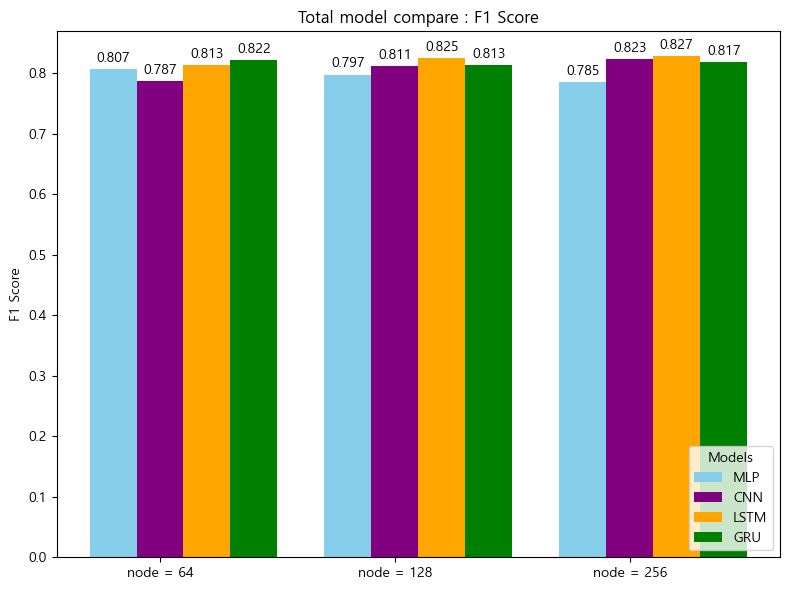

In [196]:
# 노드 수 및 모델 데이터
nodes = ['node = 64', 'node = 128', 'node = 256']
models = ['MLP', 'CNN', 'LSTM', 'GRU']

# F1 Score 데이터
f1_scores = [
    [mlp_f1_score_64, cnn_f1_score_64, lstm_f1_score_64, gru_f1_score_64],  # 64 유닛
    [mlp_f1_score_128, cnn_f1_score_128, lstm_f1_score_128, gru_f1_score_128],  # 128 유닛
    [mlp_f1_score_256, cnn_f1_score_256, lstm_f1_score_256, gru_f1_score_256]   # 256 유닛
]

# 막대 그래프 그리기
x = np.arange(len(nodes))  # 노드 수의 위치
width = 0.2  # 막대의 너비

fig, ax = plt.subplots(figsize=(8, 6))

# 색상 지정
colors = ['skyblue', 'purple', 'orange', 'green']

for i in range(len(models)):
    ax.bar(x + (i - 1) * width, [f1_scores[j][i] for j in range(len(nodes))], width, label=models[i], color=colors[i])

# 그래프에 레이블 추가
ax.set_ylabel('F1 Score')
ax.set_title('Total model compare : F1 Score')
ax.set_xticks(x)
ax.set_xticklabels(nodes)
ax.legend(title='Models', loc='lower right')  # 범례를 오른쪽 하단에 위치

# 막대 위에 값 표시
def add_value_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.3f}', 
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 포인트 위로 이동
                    textcoords="offset points",
                    ha='center', va='bottom')

for i in range(len(models)):
    add_value_labels(ax.patches[i * len(nodes):(i + 1) * len(nodes)])

plt.tight_layout()
plt.show()


#### Accuracy(정확도)

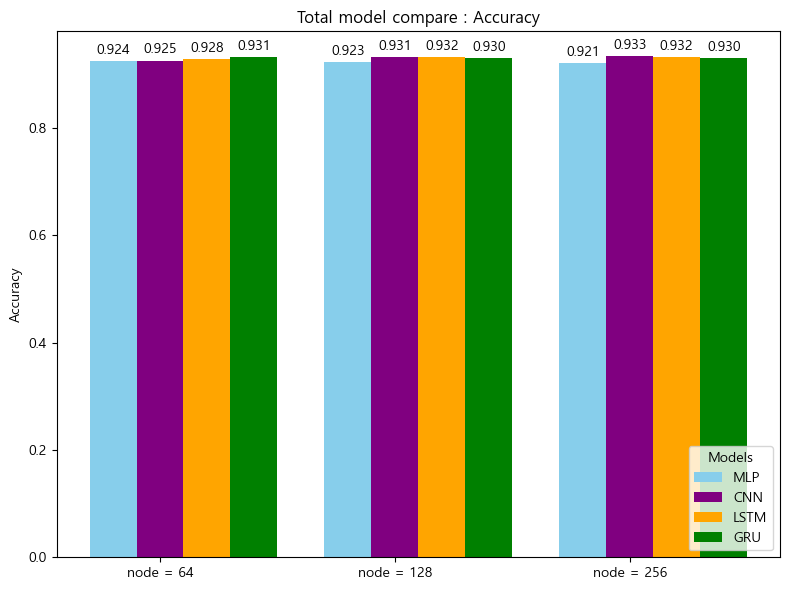

In [197]:
# 노드 수 및 모델 데이터
nodes = ['node = 64', 'node = 128', 'node = 256']
models = ['MLP', 'CNN', 'LSTM', 'GRU']

# Accuracy 데이터
acc_scores = [
    [mlp_accuracy_64, cnn_accuracy_64, lstm_accuracy_64, gru_accuracy_64],  # 64 유닛
    [mlp_accuracy_128, cnn_accuracy_128, lstm_accuracy_128, gru_accuracy_128],  # 128 유닛
    [mlp_accuracy_256, cnn_accuracy_256, lstm_accuracy_256, gru_accuracy_256]   # 256 유닛
]

# 막대 그래프 그리기
x = np.arange(len(nodes))  # 노드 수의 위치
width = 0.2  # 막대의 너비

fig, ax = plt.subplots(figsize=(8, 6))

# 색상 지정
colors = ['skyblue', 'purple', 'orange', 'green']

for i in range(len(models)):
    ax.bar(x + (i - 1) * width, [acc_scores[j][i] for j in range(len(nodes))], width, label=models[i], color=colors[i])

# 그래프에 레이블 추가
ax.set_ylabel('Accuracy')
ax.set_title('Total model compare : Accuracy')
ax.set_xticks(x)
ax.set_xticklabels(nodes)
ax.legend(title='Models', loc='lower right')  # 범례를 오른쪽 하단에 위치

# 막대 위에 값 표시
def add_value_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.3f}', 
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 포인트 위로 이동
                    textcoords="offset points",
                    ha='center', va='bottom')

for i in range(len(models)):
    add_value_labels(ax.patches[i * len(nodes):(i + 1) * len(nodes)])

plt.tight_layout()
plt.show()

### 결론

딥러닝 모델로 MLP, CNN, LSTM, GRU 4개의 모델에 대해서 성능비교를 진행    
이때 각 모델별로 은닉층의 수는 2개로 고정하고 노드의수를 64, 128, 256개로 변화를 주며 성능 비교하엿음    

ACC, AUROC(AR) 값 모두 LSTM 모델의 성능이 제일 우수  
-> 딥러닝 모델중 최종적으로 LSTM 모델을 선정  

ML 모델과 LSTM 모델을 앙상블(soft voting) 하여 성능개선을 노려볼수 있음

.